In [1]:
import numpy as np
import pandas as pd
import time
import urllib.request
import io
import zipfile
import matplotlib.pyplot as plt
from sklearn.svm import SVR
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    r2_score
)
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.preprocessing import StandardScaler

class BikeRentalSVRAnalyzer:
    """
    Bike Rental Prediction using Support Vector Regression (SVR)

    Project Objectives:
    - Predict daily bike rental counts
    - Compare performance of different SVR (Support Vector Regression) models
    - Perform hyperparameter optimization
    """
    def __init__(self, url='https://archive.ics.uci.edu/ml/machine-learning-databases/00275/Bike-Sharing-Dataset.zip'):
        """
        Loads the dataset from URL and prepares it for preprocessing

        Parameters:
        -----------
        url : str
            URL for the Bike Sharing dataset
        """
        # Load dataset from URL
        self.url = url
        self._load_data()

        # Scale features
        self.feature_scaler = StandardScaler()
        self.X_scaled = self.feature_scaler.fit_transform(self.X)

        # Hyperparameter search space
        self.param_grid = {
            'C': [0.1, 1, 10, 100],  # Regularization parameter
            'epsilon': [0.01, 0.05, 0.1],  # Error tolerance
            'kernel': ['linear', 'rbf']  # Kernel functions to use
        }

    def _load_data(self):
        """
        Downloads the dataset from URL and prepares it for preprocessing
        """
        try:
            # Download ZIP file from URL
            response = urllib.request.urlopen(self.url)
            zip_data = io.BytesIO(response.read())

            # Read day.csv from the ZIP file
            with zipfile.ZipFile(zip_data) as zip_file:
                with zip_file.open("day.csv") as file:
                    df_bike = pd.read_csv(file)

            # Remove unnecessary columns
            df_bike.drop(["instant", "dteday", "casual", "registered"], axis=1, inplace=True)

            # Separate target variable and features
            self.y = df_bike["cnt"].values
            self.X = df_bike.drop("cnt", axis=1).values

        except Exception as e:
            print(f"Data loading error: {e}")
            raise

    def cross_validation_svm_regression(self, model, X, y, n_folds=6):
        """
        Evaluate SVR model with 6-fold cross-validation

        Returns:
        --------
        dict: Model performance metrics
        """
        # Prepare cross-validation
        kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)

        # Dictionary for performance metrics
        metrics = {
            'mse_scores': [],
            'mae_scores': [],
            'r2_scores': [],
            'runtimes': [],
            'y_true_all': [],
            'y_pred_all': []
        }

        # Prepare visualization
        plt.figure(figsize=(15, 10))

        # Evaluate model performance for each fold
        for fold_idx, (train_index, test_index) in enumerate(kf.split(X)):
            # Split data
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]

            # Train model and predict
            start_time = time.time()
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            runtime = time.time() - start_time

            # Calculate performance metrics
            mse = mean_squared_error(y_test, y_pred)
            mae = mean_absolute_error(y_test, y_pred)
            r2 = r2_score(y_test, y_pred)

            # Store metrics
            metrics['mse_scores'].append(mse)
            metrics['mae_scores'].append(mae)
            metrics['r2_scores'].append(r2)
            metrics['runtimes'].append(runtime)
            metrics['y_true_all'].extend(y_test)
            metrics['y_pred_all'].extend(y_pred)

            # Visualize predictions for each fold
            plt.subplot(2, 3, fold_idx + 1)
            plt.scatter(y_test, y_pred, color='blue', alpha=0.7, label='Predictions')
            plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()],
                     color='red', linestyle='--', label='Ideal Prediction')
            plt.title(f"Fold {fold_idx + 1}: R² = {r2:.2f}")
            plt.xlabel('Actual Values')
            plt.ylabel('Predicted Values')
            plt.legend()

            # Print fold-by-fold performance
            print(f"Fold {fold_idx + 1}: "
                  f"MSE = {mse:.2f}, "
                  f"MAE = {mae:.2f}, "
                  f"R² = {r2:.2f}, "
                  f"Runtime = {runtime:.4f} s")

        # Finalize visualization
        plt.tight_layout()
        plt.suptitle('SVR Performance: Actual vs Predicted Values', fontsize=16)
        plt.show()

        # Calculate and return summary metrics
        return {
            'average_mse': np.mean(metrics['mse_scores']),
            'average_mae': np.mean(metrics['mae_scores']),
            'average_r2': np.mean(metrics['r2_scores']),
            'average_runtime': np.mean(metrics['runtimes']),
            'actual_values': metrics['y_true_all'],
            'predicted_values': metrics['y_pred_all']
        }

    def hyperparameter_optimization(self):
        """
        Find the best hyperparameters using GridSearchCV

        Returns:
        --------
        dict: Best hyperparameters
        """
        print("\n=== Hyperparameter Optimization ===")

        # Set up GridSearchCV
        grid_search = GridSearchCV(
            SVR(),
            self.param_grid,
            cv=3,
            scoring='neg_mean_squared_error',
            n_jobs=-1
        )

        # Find the best parameters
        grid_search.fit(self.X_scaled, self.y)

        # Print the best parameters
        best_params = grid_search.best_params_
        print("Best parameters found:", best_params)

        return best_params

    def analysis_report(self):
        """
        Comprehensive SVR regression analysis
        """
        print("=== Linear SVM Regression Analysis ===")

        # Base Linear SVR
        print("\n1. Base Linear SVR Performance:")
        linear_svr_model = SVR(kernel="linear")
        base_results = self.cross_validation_svm_regression(
            linear_svr_model,
            self.X_scaled,
            self.y
        )

        # Hyperparameter Optimization
        best_parameters = self.hyperparameter_optimization()

        # Best SVR Model
        print("\n2. Best SVR Model Performance:")
        best_svr_model = SVR(**best_parameters)
        best_results = self.cross_validation_svm_regression(
            best_svr_model,
            self.X_scaled,
            self.y
        )

        # Comparative Report
        self._comparative_report(
            base_results,
            best_results,
            best_parameters
        )

    def _comparative_report(self, base, best, best_parameters):
        """
        Detailed performance comparison report
        """
        print("\n=== Performance Comparison Report ===")
        print("\nBase Linear SVR:")
        print(f"  Average MSE:      {base['average_mse']:.2f}")
        print(f"  Average MAE:      {base['average_mae']:.2f}")
        print(f"  Average R²:       {base['average_r2']:.2f}")
        print(f"  Average Runtime:  {base['average_runtime']:.4f} s")

        print("\nBest Tuned SVR:")
        print(f"  Best Hyperparameters: {best_parameters}")
        print(f"  Average MSE:      {best['average_mse']:.2f}")
        print(f"  Average MAE:      {best['average_mae']:.2f}")
        print(f"  Average R²:       {best['average_r2']:.2f}")
        print(f"  Average Runtime:  {best['average_runtime']:.4f} s")

=== Linear SVM Regression Analysis ===

1. Base Linear SVR Performance:
Fold 1: MSE = 2134706.36, MAE = 1243.82, R² = 0.50, Runtime = 0.1224 s
Fold 2: MSE = 1733346.79, MAE = 1074.84, R² = 0.50, Runtime = 0.0379 s
Fold 3: MSE = 1720867.92, MAE = 1012.86, R² = 0.49, Runtime = 0.1591 s
Fold 4: MSE = 2131604.32, MAE = 1182.46, R² = 0.49, Runtime = 0.0371 s
Fold 5: MSE = 1748730.04, MAE = 1040.54, R² = 0.44, Runtime = 0.0848 s
Fold 6: MSE = 1800393.16, MAE = 1138.23, R² = 0.52, Runtime = 0.0598 s


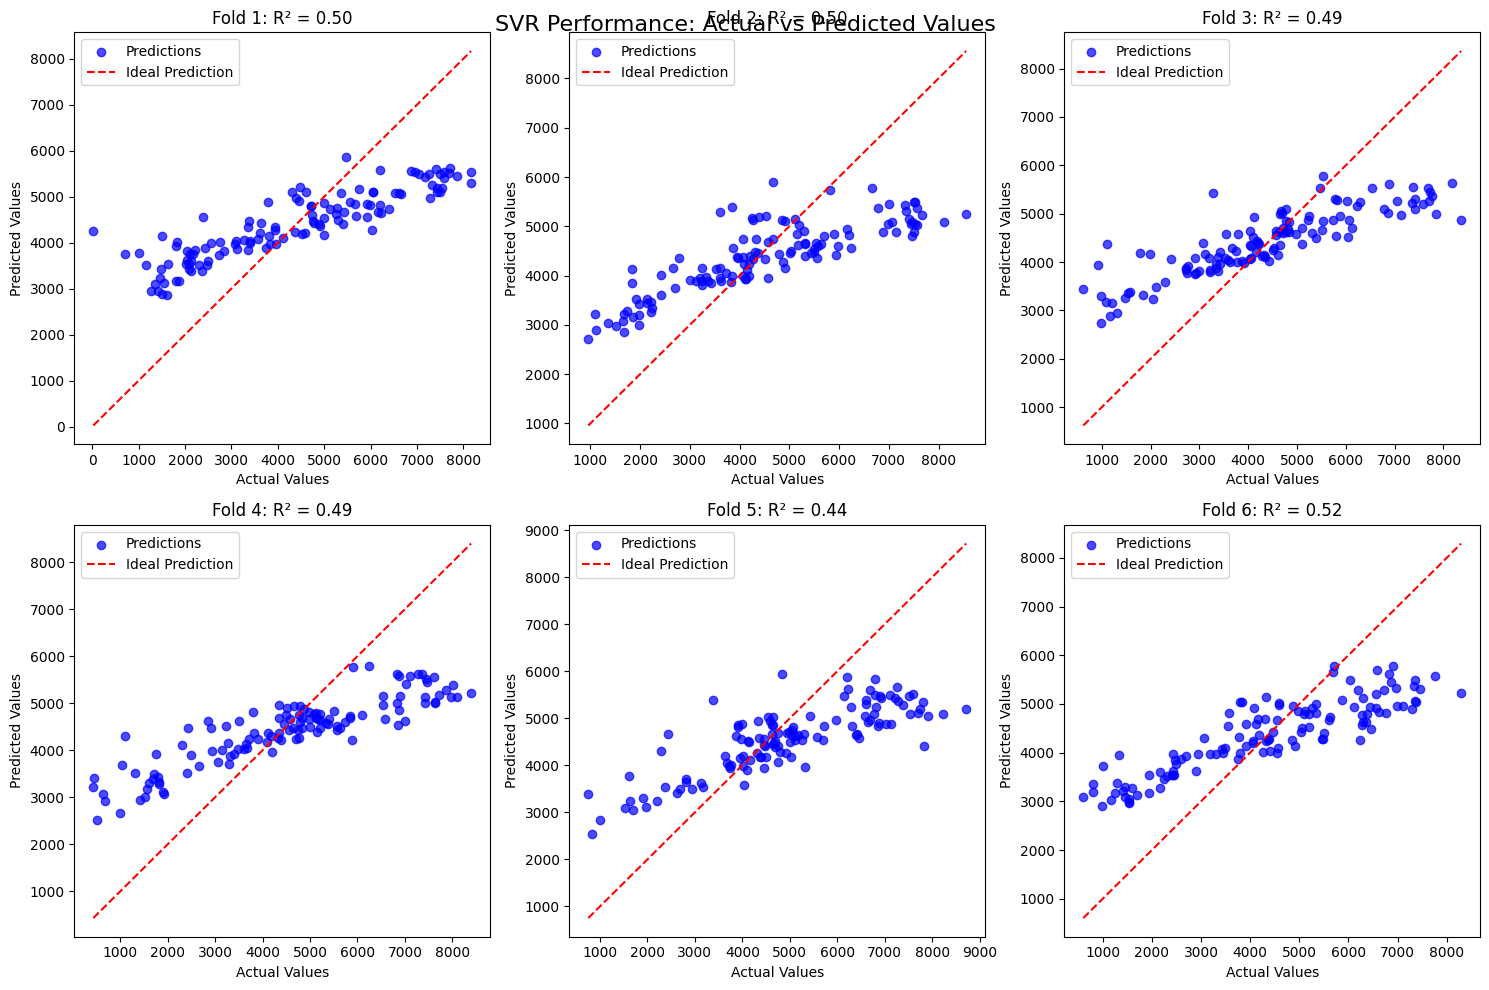


=== Hyperparameter Optimization ===
Best parameters found: {'C': 100, 'epsilon': 0.1, 'kernel': 'linear'}

2. Best SVR Model Performance:
Fold 1: MSE = 746893.52, MAE = 623.18, R² = 0.83, Runtime = 0.0332 s
Fold 2: MSE = 760412.59, MAE = 657.04, R² = 0.78, Runtime = 0.0496 s
Fold 3: MSE = 724803.64, MAE = 619.24, R² = 0.79, Runtime = 0.0396 s
Fold 4: MSE = 863770.36, MAE = 659.34, R² = 0.79, Runtime = 0.0500 s
Fold 5: MSE = 1004481.78, MAE = 728.64, R² = 0.68, Runtime = 0.0311 s
Fold 6: MSE = 626695.27, MAE = 613.25, R² = 0.83, Runtime = 0.0497 s


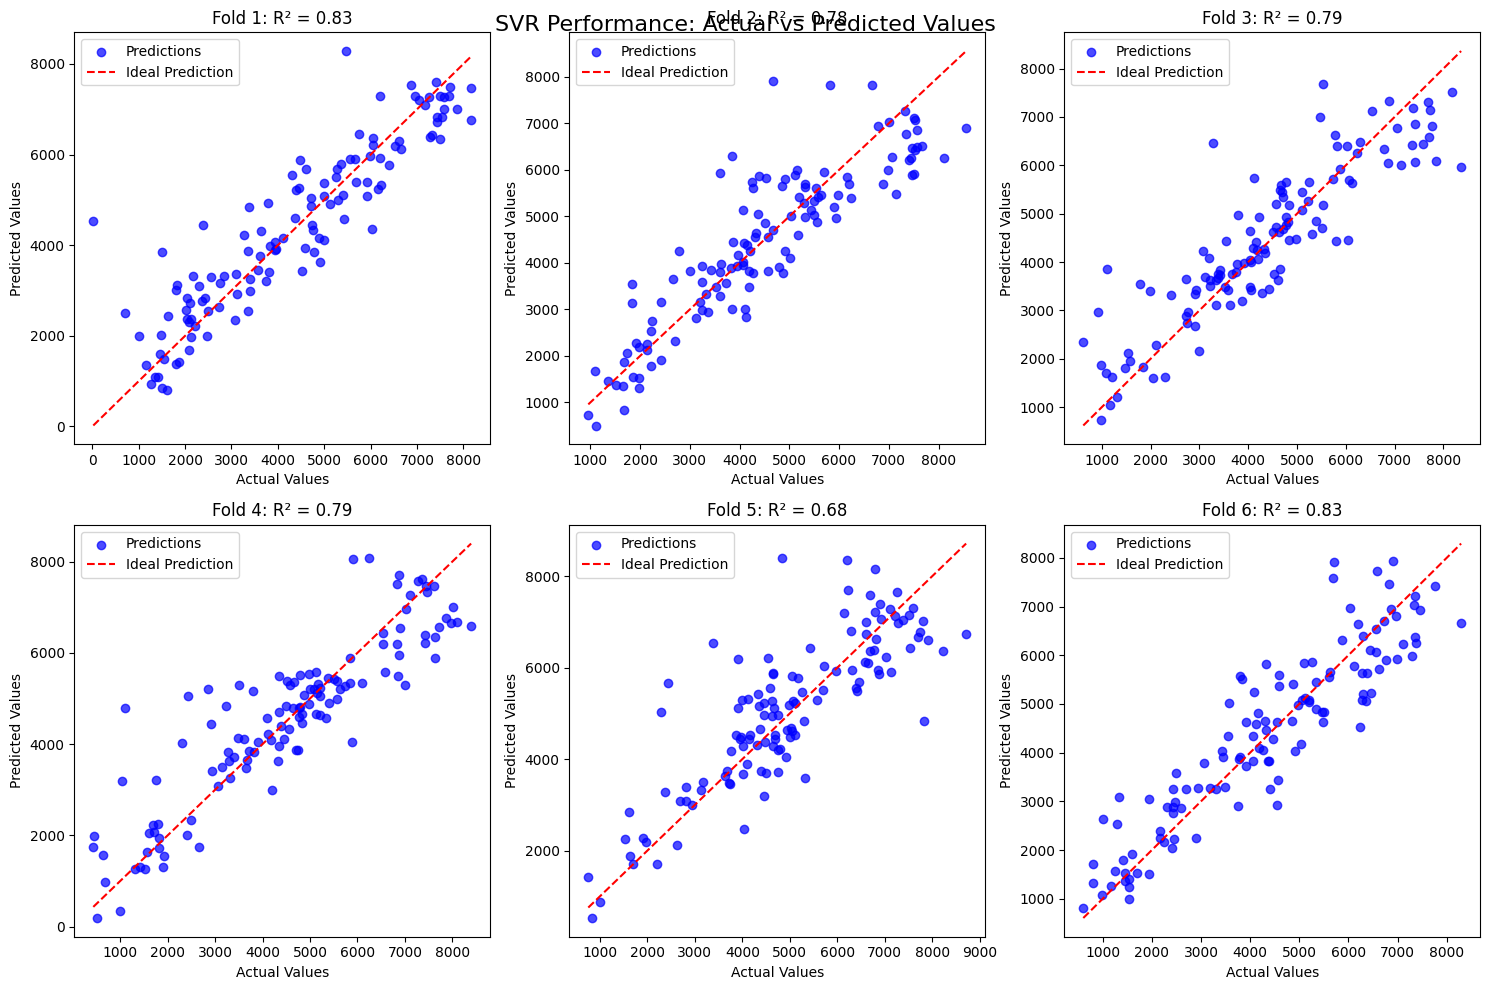


=== Performance Comparison Report ===

Base Linear SVR:
  Average MSE:      1878274.77
  Average MAE:      1115.46
  Average R²:       0.49
  Average Runtime:  0.0835 s

Best Tuned SVR:
  Best Hyperparameters: {'C': 100, 'epsilon': 0.1, 'kernel': 'linear'}
  Average MSE:      787842.86
  Average MAE:      650.12
  Average R²:       0.78
  Average Runtime:  0.0422 s


In [2]:
def main():
    """
    Main execution function for analysis
    """
    # Create and run the analysis object
    bike_rental_analysis = BikeRentalSVRAnalyzer()
    bike_rental_analysis.analysis_report()

if __name__ == "__main__":
    main()

# **Methodology**

## 1. Project Structure and Design

The first step in the implementation was designing a comprehensive *BikeRentalSVRAnalyzer* class to encapsulate all aspects of the SVR analysis workflow. This object-oriented approach provides several advantages, including modularity, code reusability, and a clear organization of related functionality. The class handles data acquisition, preprocessing, model training, cross-validation, hyperparameter optimization, and performance reporting in a cohesive structure. By using a class-based architecture, the project maintains a clean separation of concerns, making the code more maintainable and extensible.


## 2. Data Preprocessing

The implementation includes a robust data acquisition mechanism that retrieves the Bike Sharing dataset directly from the UCI Machine Learning Repository. This approach ensures reproducibility by eliminating dependencies on local data files. The _load_data() method handles the entire process, from downloading the zipped dataset to creating a structured DataFrame. The preprocessing steps include:

  1. Removing unnecessary columns ("instant", "dteday", "casual", "registered") that don't contribute to the prediction task

  2. Separating the target variable ("cnt" - daily bike rental count) from the feature set

  3. Applying standardization to the features using StandardScaler, which normalizes each feature to have zero mean and unit variance

This standardization step is particularly important for SVM models, as they are sensitive to the scale of input features. By standardizing, we ensure that all features contribute equally to the distance calculations used by the SVR algorithm.


## 3. Base Model Implementation

After data preprocessing, a base SVR model with a linear kernel was implemented to establish a performance baseline. The selection of a linear kernel for the base model was deliberate, as it provides a simpler model with fewer hyperparameters to tune initially. The linear SVR model attempts to find a linear function that approximates the relationship between features and the target variable, with a margin of tolerance defined by the epsilon parameter.


## 4. Cross-Validation Implementation

A critical component of the implementation is the comprehensive cross-validation strategy, implemented in the cross_validation_svm_regression method. This approach uses 6-fold cross-validation to provide a robust assessment of model performance across different data subsets. For each fold:

  * The data is split into training and testing sets
  * The model is trained on the training data and used to make predictions on the test data
  * Performance metrics (MSE, MAE, R²) are calculated
  * Runtime performance is measured
  * Actual vs. predicted values are visualized in a scatter plot

The cross-validation procedure is essential for obtaining reliable performance estimates, as it reduces the risk of overfitting to a particular train-test split. By evaluating the model on six different data splits and averaging the results, we obtain a more accurate assessment of how the model would perform on unseen data.

The implementation also tracks and visualizes the model's predictions across all folds, enabling a detailed analysis of prediction patterns and potential areas for improvement.


## 5. Hyperparameter Optimization

To enhance model performance, a hyperparameter optimization process was implemented using GridSearchCV from scikit-learn. This step systematically explores different combinations of hyperparameters to identify the configuration that minimizes prediction error. The implementation considers the following hyperparameters:

  * C: [0.1, 1, 10, 100] - The regularization parameter that controls the trade-off between achieving a low training error and a low testing error

  * epsilon: [0.01, 0.05, 0.1] - The margin of tolerance where no penalty is given to errors

  * kernel: ['linear', 'rbf'] - The kernel function, with 'rbf' (Radial Basis Function) offering potentially better performance for non-linear relationships

The hyperparameter optimization uses 3-fold cross-validation and the negative mean squared error as the scoring metric. By employing n_jobs=-1, the process leverages all available CPU cores for parallel computation, significantly reducing the time required for the grid search.

This comprehensive hyperparameter search enables the discovery of the optimal model configuration that balances complexity and generalization ability.


# **Performance Analysis**

## 1. Performance Comparison Overview

The results demonstrate a significant improvement in prediction performance between the base Linear SVR model and the optimized SVR model. The hyperparameter optimization process identified an optimal configuration with C=100, epsilon=0.1, and a linear kernel, resulting in substantially better predictive accuracy.


## 2. Base Linear SVR Performance

The base Linear SVR model (with default parameters) showed modest performance:

  * Average MSE: 1,878,274.77
  * Average MAE: 1,115.46
  * Average R²: 0.49
  * Average Runtime: 0.0835 seconds

The R² value of 0.49 indicates that the model explains approximately half of the variance in the bike rental counts, suggesting room for improvement. The high MSE value also indicates substantial prediction errors.


## 3. Optimized SVR Performance

The hyperparameter-optimized SVR model demonstrated markedly superior performance:

  * Average MSE: 787,842.86 (58% reduction from base model)
  * Average MAE: 650.12 (42% reduction from base model)
  * Average R²: 0.78 (59% improvement from base model)
  * Average Runtime: 0.0422 seconds (49% faster than base model)

The optimized model increased the explained variance from 49% to 78%, a substantial improvement in predictive power. Both error metrics (MSE and MAE) show significant reductions, with the MSE less than half of the base model's value.


## 4. Key Insights

  * Hyperparameter Importance: The optimization process retained the linear kernel but significantly increased the regularization parameter (C=100), demonstrating that the appropriate level of regularization is crucial for this dataset.

  * Consistency Across Folds: The optimized model shows consistent performance across all six folds, with R² values ranging from 0.68 to 0.83, indicating robust generalization capability.

  * Computational Efficiency: Interestingly, the optimized model runs approximately twice as fast as the base model despite its increased complexity. This efficiency gain may be attributed to better convergence properties of the optimized parameters.

  * Error Reduction: The substantial reduction in both MSE and MAE indicates that the optimized model makes significantly more accurate predictions overall, with fewer large errors.


# **Conclusion**

The hyperparameter optimization process has yielded a substantially improved SVR model for bike rental prediction. The optimized model not only provides much higher prediction accuracy (78% of variance explained) but also operates with greater computational efficiency. The retention of the linear kernel suggests that the relationship between features and bike rental counts can be effectively captured by a linear model when properly regularized, without needing to resort to more complex kernel functions.
